<a href="https://colab.research.google.com/github/watanabe-gk/study_gpt/blob/main/%E4%BA%8B%E5%89%8D%E5%AD%A6%E7%BF%92.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title モジュールのインストール
!pip install -qq datasets==2.18
!pip install -qq mecab-python3==1.0.8
!pip install -qq unidic-lite
!git clone https://github.com/Michi-123/whiteGPT.git

fatal: destination path 'whiteGPT' already exists and is not an empty directory.


<h1><font color="cyan">None</font>の部分を書き換えていきましょう</h1>

In [ ]:
#@title ライブラリーのインポート
import math
import torch
import torch.nn as nn
import torch.optim as optim # 最適化モジュール
from matplotlib import pyplot as plt # グラフの描画
import MeCab # 形態素解析

In [ ]:
#@title Google Driveのマウント
# from google.colab import drive
# drive.mount('/content/drive')

GPUの使用を判定

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
#@title MeCabの利用 (日本語を形態素解析するプログラム)
tagger = MeCab.Tagger("-Owakati")

In [ ]:
# @title Exercise
tagger.parse('私は昨日公園にいきました')

'私 は 昨日 公園 に いき まし た \n'

In [ ]:
# @title 青空文庫データセットの利用
from datasets import load_dataset
ds = load_dataset('globis-university/aozorabunko-clean')
ds = ds.filter(lambda row: row['meta']['文字遣い種別'] == '新字新仮名')  # 新字新仮名に限定

In [ ]:
authors = ['夏目'] #@param
# titles = [ 'こころ', '三四郎' ,'それから', '坊っちゃん']#@param
titles = ['文鳥', '正岡子規']#@param
corpus = ''
for book in ds['train']:
    title = book['meta']['作品名']
    author = book['meta']['姓']
    # if author in authors:
    if title in titles and author in authors:
        print(author, title)
        text = book['text'] # 本文
        text = ''.join(text.split()) # Clean up
        text = tagger.parse(text) # 形態素解析
        corpus += text

print(corpus[:100])

夏目 文鳥
夏目 正岡子規
十 月 早稲田 に 移る 。 伽藍 の よう な 書斎 に ただ 一人 、 片づけ た 顔 を 頬杖 で 支え て いる と 、 三重吉 が 来 て 、 鳥 を 御 飼い なさい と 云う 。 飼っ 


# Hyper parameter

In [ ]:
# @markdown Model parameters

# 512 token GPT1
# 10
context_size = 10 # @param {type: "integer"}

# 768 GPT1 (512+256)
# 192
d_model = 64 #@param {type: "integer"}

# 12 GPT1
# 3
n_head = 2 #@param {type: "integer"}

# 12 layer in  GPT1
# 6
n_block = 3 #@param {type: "integer"}

# @markdown Train parameters
# 64 GPT1
# 64
batch_size = 64  #@param {type: "integer"}

# 2.5e-4
# 0.00025
leraning_rate = 0.00025  #@param {type: "number"}

# 100 GPT1
epoch_num = 150 #@param {type: "integer"}

# pre-trained.pkl
pre_trained_model_path = 'pre-trained.pkl' #@param {type: "string"}

In [ ]:
# ハイパーパラメータの検証
if d_model % n_head != 0:
    print("埋め込みベクトルの次元はヘッドの数で割り切れる必要があります")
    raise ValueError("d_model must be divisible by n_head")

# インスタンス化

In [ ]:
from whiteGPT import GPT, create_attention_mask # 完成コードの利用
from whiteGPT import DataLoader, Evaluate
from whiteGPT import JpTextDataset as Dataset

In [ ]:
from random import shuffle
# Dataset と DataLoader
dataset = Dataset(corpus, context_size)
train_dataloader = DataLoader(dataset, batch_size, shuffle=True)
test_dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

In [ ]:
# マスク関数
mask = create_attention_mask(context_size).to(device)

In [ ]:
# 評価モジュールの利用
evaluate = Evaluate(dataset, context_size)

In [ ]:
# 語彙数の取得
vocab_size = len(dataset.vocab)
vocab_size

1596

In [ ]:
# GPTモデルの作成とデバイス対応
model = GPT(vocab_size, context_size, d_model, n_head, n_block).to(device)

In [ ]:
# クロスエントロピー誤差
criterion = nn.CrossEntropyLoss()
# 最適化モジュールの利用
optimizer = optim.Adam(model.parameters(), lr=leraning_rate)

In [ ]:
is_load_model = False # @param{type:"boolean"}
if is_load_model:
    model.load_state_dict(torch.load(pre_trained_model_path, map_location=device))
    print('ok')

# 学習

In [ ]:
#@title 初期化
start_epoch = 0
history = {"train_loss": []}
attn_list = [] # 潜在空間の可視化

epoch:1  index:148 loss:6.635508
source 手 を そろそろ 籠 の 中 へ 入れ た 。 
target する
output て

epoch:2  index:148 loss:5.482486
source いけ ない お よし なさい と 頻り に いう 。 
target 僕
output 。

epoch:3  index:148 loss:5.462232
source を 曲げ て 人 を 見る 癖 が あっ た 
target 。
output 。

epoch:4  index:148 loss:5.458275
source その 頃 は 日課 と し て 小説 を 書い 
target て
output 。

epoch:5  index:148 loss:5.456440
source し て 入れ て あっ た 粟 が はらはら と 
target 籠
output 。

epoch:6  index:148 loss:5.457127
source ない と いまいましい から 、 気 に かから ない で 
target は
output 。



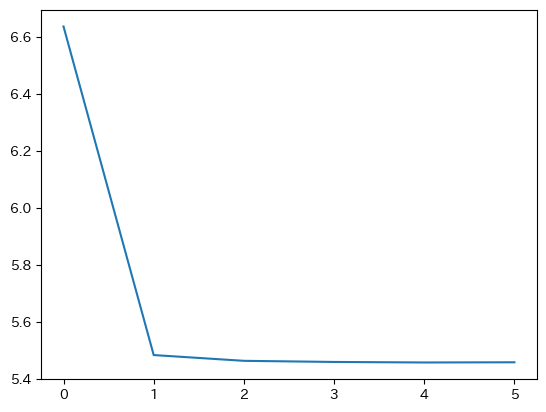

epoch:7  index:148 loss:5.455390
source 広い 縁側 が ほの 明るく 見える なか に 、 鳥籠 
target が
output 。

epoch:8  index:148 loss:5.455384
source 見せる 。 其 時分 は 冬 だっ た 。 大将 
target 雪隠
output 。

epoch:9  index:148 loss:5.454685
source 汚し ます から 、 時々 掃除 を し て お 
target やり
output 。

epoch:10  index:148 loss:5.454252
source 。 自分 は 外套 の 羽根 を 返し て 、 
target すぐ
output 。

epoch:11  index:148 loss:5.454215
source 膨 くらん だ 首 を 惜 気 も なく 右左 
target へ
output 。



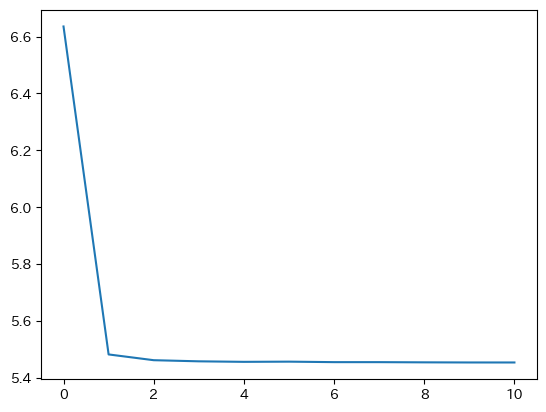

epoch:12  index:148 loss:5.453436
source よう で ある 。 その 紅 が しだい に 流れ 
target て
output 。

epoch:13  index:148 loss:5.453577
source さあさあ と かけ て やっ た 。 如 露 の 
target 水
output 。

epoch:14  index:148 loss:5.446680
source 硝子 越 に 庭 の 霜 を 眺め て い 
target た
output 。

epoch:15  index:148 loss:5.399380
source また 怠け た 。 昔 の 女 の 顔 も 
target つい
output て

epoch:16  index:148 loss:5.275832
source を 見上げ た 。 それ から 曲げ た 首 を 
target 真直
output を



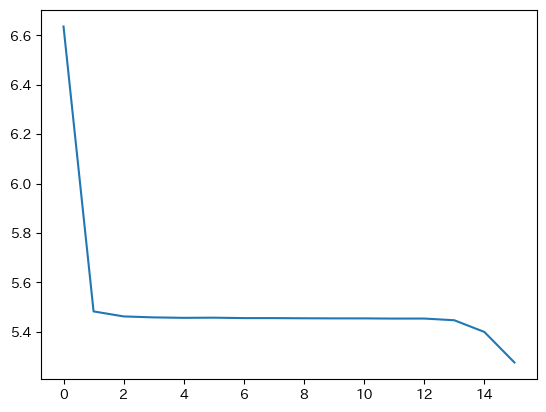

epoch:17  index:148 loss:5.105608
source を 縁 に 置い て 、 上 から こごん で 
target 籠
output に

epoch:18  index:148 loss:4.943158
source も 多少 気味 が 悪かっ た 。 けれど も 断わら 
target ん
output て

epoch:19  index:148 loss:4.778331
source 例 に 似 ず 留り 木 の 上 に じっと 
target 留っ
output て

epoch:20  index:148 loss:4.642161
source 時 僕 が 房州 に 行っ た 時 の 紀行 
target 文
output の

epoch:21  index:148 loss:4.507949
source 出来る 男 で は なかっ た 。 例えば 発句 など 
target を
output を



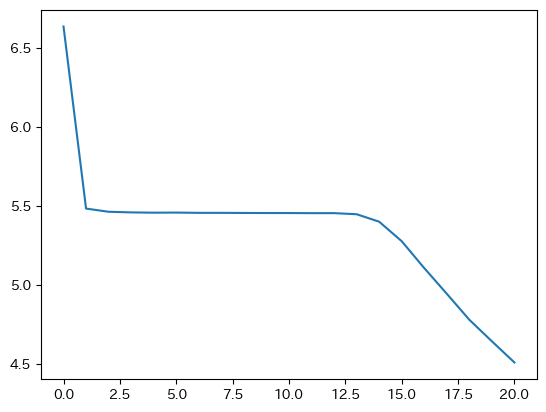

epoch:22  index:148 loss:4.391282
source を ぱち つか せ て いる 。 もっと 早く 起き 
target たかっ
output と

epoch:23  index:148 loss:4.256311
source の 顔 を 見 て ことさら に 鳴く 気色 は 
target さらに
output 文鳥

epoch:24  index:148 loss:4.130697
source を 引き込ま し た 。 籠 の 戸 は はたり 
target と
output を

epoch:25  index:148 loss:4.001912
source 。 自分 は 手紙 の 筆 を 留め た 。 
target 文鳥
output 自分

epoch:26  index:148 loss:3.872364
source の まま 長らく 留り 木 の 上 を 動か なかっ 
target た
output た



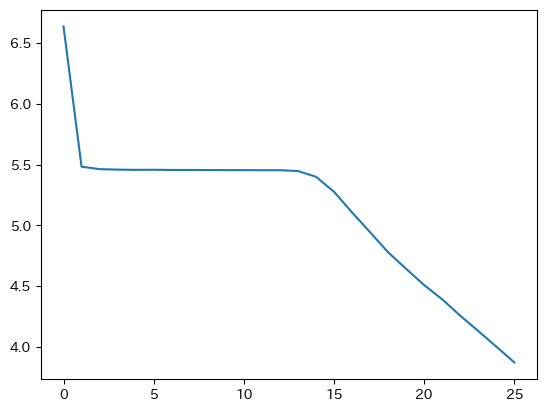

epoch:27  index:148 loss:3.745841
source に 軽そう だ 。 文鳥 は 身 を 逆さま に 
target し
output 、

epoch:28  index:148 loss:3.630125
source から 、 もう 死ん だ か も 知れ ませ ん 
target と
output 。

epoch:29  index:148 loss:3.509235
source 文鳥 は いっこう 不平 らしい 顔 も し なかっ た 
target 。
output 。

epoch:30  index:148 loss:3.390185
source 云う 。 で も 君 あて が なくっ ちゃ いけ 
target なかろう
output の

epoch:31  index:148 loss:3.284106
source ため 一応 縁側 へ 廻っ て 見る と ― ― 
target 籠
output で



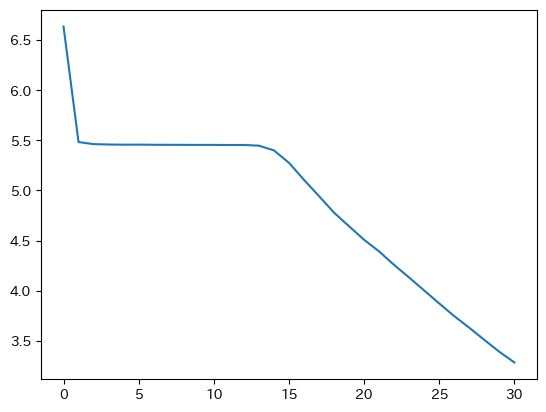

epoch:32  index:148 loss:3.176161
source する と 文鳥 が 行水 を 使っ て い た 
target 。
output 。

epoch:33  index:148 loss:3.075252
source 、 当人 一人 で 極めて 居る 。 御 承知 の 
target 通り
output 通り

epoch:34  index:148 loss:2.958759
source は 文鳥 に すま ない と 思っ た 。 殻 
target は
output は

epoch:35  index:148 loss:2.848966
source か も 知れ ない 。 しかし 当人 は いっこう そんな 
target 事
output の

epoch:36  index:148 loss:2.741444
source 同級 生 など も 滅茶苦茶 で あっ た 。 非常 
target に
output に



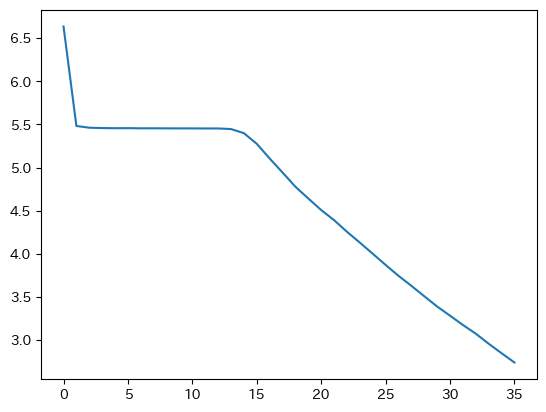

epoch:37  index:148 loss:2.639119
source の 中 に 入れる 癖 が ある 。 自分 は 
target 三重吉
output 僕

epoch:38  index:148 loss:2.519006
source 常盤 会 寄宿 舎 に 居 た もの だ から 
target 、
output 、

epoch:39  index:148 loss:2.412875
source か 淡雪 の 精 の よう な 気 が し 
target た
output た

epoch:40  index:148 loss:2.326243
source なるほど 立派 な 籠 が でき た 。 台 が 
target 漆
output 漆

epoch:41  index:148 loss:2.215612
source 薄暗い 中 に 真白 に 見える 。 籠 の 中 
target に
output に



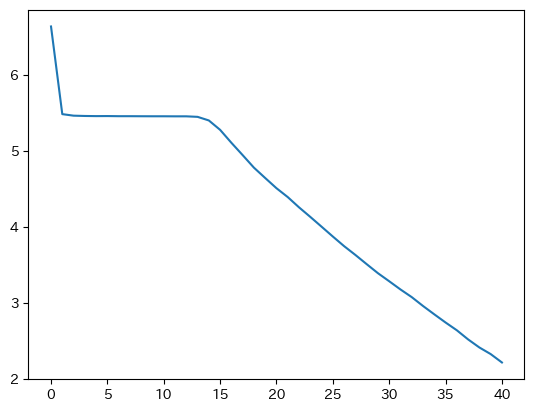

epoch:42  index:148 loss:2.140680
source は これ で 二 返 目 で ある 。 二十 
target 円
output 非常

epoch:43  index:148 loss:2.049040
source 文鳥 を 握っ て 、 小女 の 前 へ 抛り出し 
target た
output た

epoch:44  index:148 loss:1.969891
source し て 時々 は 首 を 伸し て 籠 の 
target 外
output 底

epoch:45  index:148 loss:1.900341
source は この 朝 、 三重吉 から 例 の 件 で 
target 某所
output 某所

epoch:46  index:148 loss:1.839090
source 見る と 、 公 札 の 表 に は 、 
target この
output 外



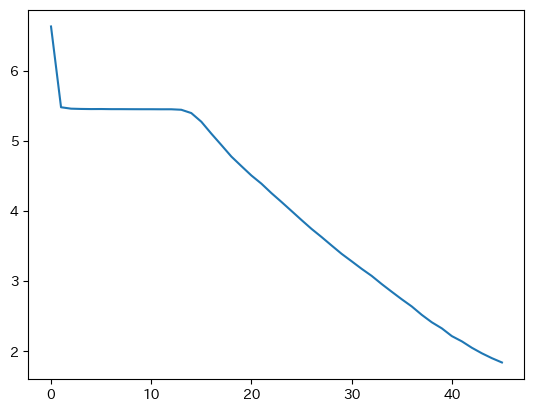

epoch:47  index:148 loss:1.760755
source から 、 念 の ため 一応 縁側 へ 廻っ て 
target 見る
output 見る

epoch:48  index:148 loss:1.712425
source の 方 が 旨かっ た 。 尤も 今 から 見 
target たら
output た

epoch:49  index:148 loss:1.659967
source は たいてい 机 に 向っ て 筆 を 握っ て 
target い
output い

epoch:50  index:148 loss:1.603739
source わけ で も 無い の だ が 、 自然 と 
target そう
output 思っ

epoch:51  index:148 loss:1.554298
source が 、 彼 と 僕 と 交際 し 始め た 
target も
output 。



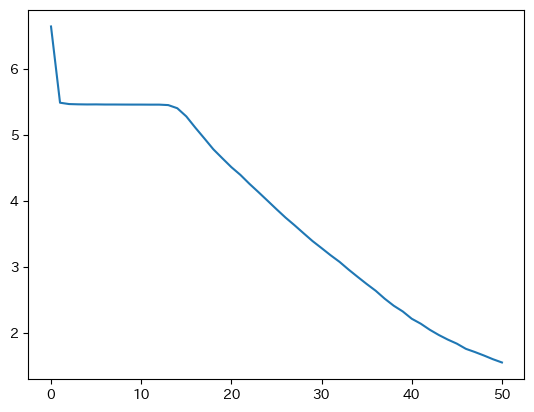

epoch:52  index:148 loss:1.495076
source 飯 を 食わ せる から 厭 だ と いっ た 
target 。
output 。

epoch:53  index:148 loss:1.465648
source 頭 から けなし ちゃ いか ない 。 けなし つつ 作れ 
target ば
output ば

epoch:54  index:148 loss:1.409874
source の 足 の 立っ て い た 時分 だ 。 
target 正岡
output それ

epoch:55  index:148 loss:1.368719
source 事 を 一 つ 二 つ 話そう か 。 正岡 
target と
output の

epoch:56  index:148 loss:1.335888
source いる 。 高 さ は 木賊 より も ずっと 低い 
target 。
output に



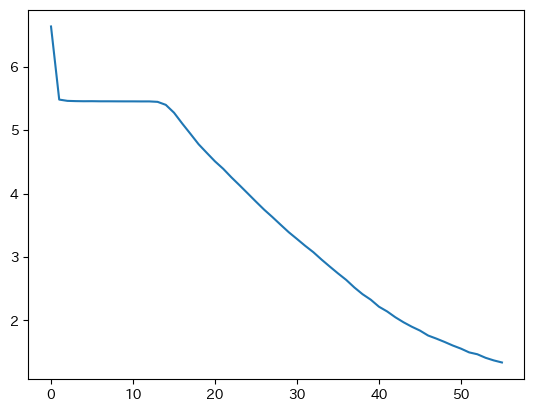

epoch:57  index:148 loss:1.303417
source は 、 二人 で 寄席 の 話 を し た 
target 時
output 。

epoch:58  index:148 loss:1.243998
source て い た 処 も あっ たろう 。 も 一 
target つ
output つ

epoch:59  index:148 loss:1.227121
source 首 を 二三 度 竪 横 に 向け直し た 。 
target やがて
output やがて

epoch:60  index:148 loss:1.185343
source ついで を もっ て 、 冷たい 縁 を 素足 で 
target 踏み
output 踏み

epoch:61  index:148 loss:1.159652
source 下 に ある 粟 と 水 を 眺め た 。 
target 自分
output 僕



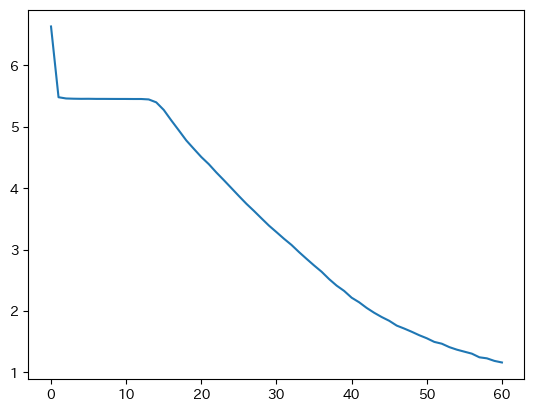

epoch:62  index:148 loss:1.121654
source を 止め て 近 処 の 西洋 料理 屋 か 
target 何
output 何

epoch:63  index:148 loss:1.093677
source あまり に 仰山 で ある 。 雛段 を あるく 、 
target 内裏
output 内裏

epoch:64  index:148 loss:1.062084
source 。 女 が 長い 衣 の 裾 を 捌い て 
target いる
output いる

epoch:65  index:148 loss:1.036174
source て 、 烈しく 手 を 鳴らし た 。 十 六 
target に
output に

epoch:66  index:148 loss:1.005505
source 自分 は 、 餌 を やら ない から 、 とうとう 
target 死ん
output 死ん



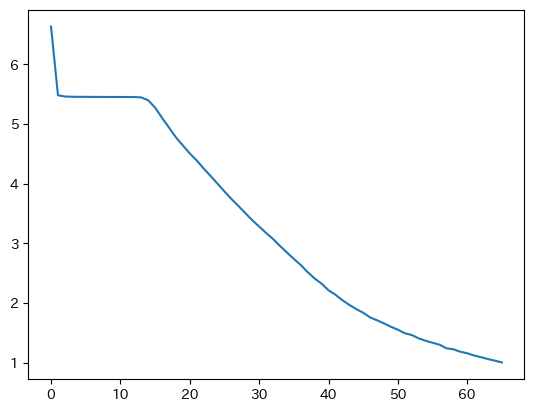

epoch:67  index:148 loss:0.974389
source て い た 。 すれっからし で あっ た 。 （ 
target 悪い
output 悪い

epoch:68  index:148 loss:0.947450
source 振り廻す の に 恐れ を 為し て い た 程 
target 、
output 、

epoch:69  index:148 loss:0.913948
source 、 新聞 の 論説 の 仮名 を 抜い た 様 
target な
output な

epoch:70  index:148 loss:0.887026
source 、 それ から 糞 を し て 籠 を 汚し 
target ます
output ます

epoch:71  index:148 loss:0.873762
source へ 廻っ て 見る と ― ― 籠 は 箱 
target の
output の



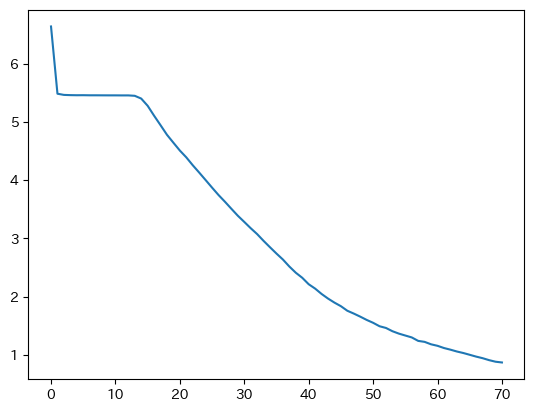

epoch:72  index:148 loss:0.847353
source 硝子 戸 を 透し て 五 尺 の 縁側 に 
target は
output 縁側

epoch:73  index:148 loss:0.831515
source と 、 二 本 の 留り 木の間 を 、 あちら 
target へ
output に

epoch:74  index:148 loss:0.799300
source と 上 へ 押し上げ た 。 同時 に 左 の 
target 手
output 手

epoch:75  index:148 loss:0.774130
source 首 を 二三 度 竪 横 に 向け直し た 。 
target やがて
output やがて

epoch:76  index:148 loss:0.757541
source 平凡 な 答 を し た 。 籠 は と 
target 聞き返す
output 聞き返す



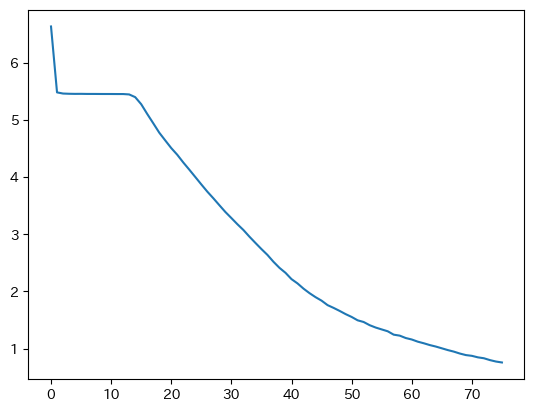

epoch:77  index:148 loss:0.738995
source を 使っ て いる 。 自分 は 急 に 易 
target 籠
output 籠

epoch:78  index:148 loss:0.707062
source 読む 方 で も 無かっ た が 、 兎に角 自分 
target の
output 女

epoch:79  index:148 loss:0.688734
source 仕方 が ない から 顔 を 洗う ついで を もっ 
target て
output て

epoch:80  index:148 loss:0.669156
source あっ た 。 これ は まだ 正岡 の 足 の 
target 立っ
output は

epoch:81  index:148 loss:0.657816
source 硝子 越 に 庭 の 霜 を 眺め て い 
target た
output た



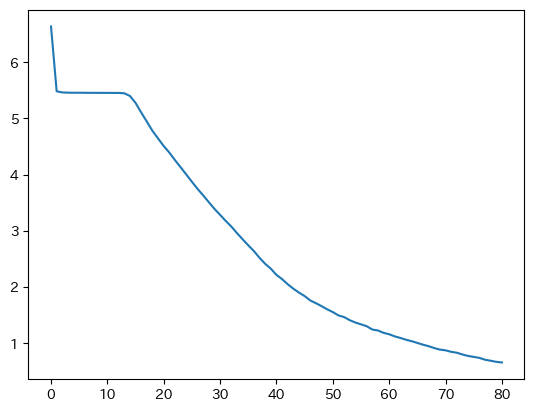

epoch:82  index:148 loss:0.638201
source 、 子規 は 支那 から 帰っ て 来 て 僕 
target の
output よう

epoch:83  index:148 loss:0.626760
source 話そう か 。 正岡 と いう 男 は 一向 学校 
target へ
output へ

epoch:84  index:148 loss:0.604871
source から 出 ながら 千代 千代 と 二 声 鳴い た 
target 。
output 。

epoch:85  index:148 loss:0.584199
source べき は 一 粒 も ない 。 水 入 は 
target 底
output 底

epoch:86  index:148 loss:0.566669
source 取乱し て み たり 、 頬杖 を 突い たり やめ 
target たり
output たり



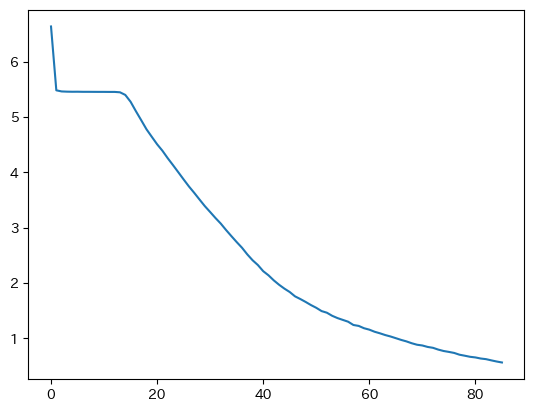

epoch:87  index:148 loss:0.559155
source 文鳥 が たちまち 千代 千代 と 二 声 鳴い た 
target 。
output 。

epoch:88  index:148 loss:0.539049
source いる ところ を 、 後 から 、 そっと 行っ て 
target 、
output 、

epoch:89  index:148 loss:0.532481
source 粉 など を 人 指 指 の 先 へ つけ 
target て
output て

epoch:90  index:148 loss:0.503809
source に は 白い 羽根 から 落ちる 水 が 珠 に 
target なっ
output なっ

epoch:91  index:148 loss:0.507006
source も せ ぬ もの を 頻り に ひっくりかえし て い 
target た
output た



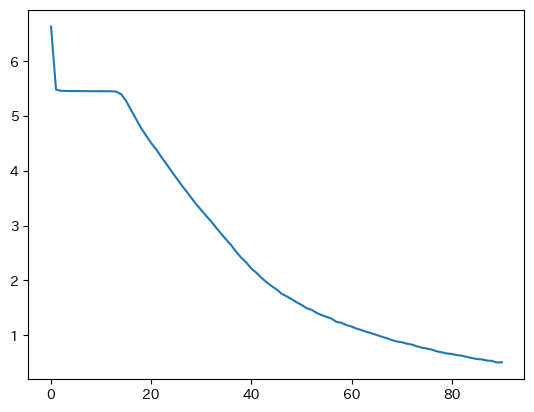

epoch:92  index:148 loss:0.482527
source 文鳥 が 人 の 顔 を 見 て 鳴く よう 
target に
output な

epoch:93  index:148 loss:0.468744
source は 当地 に 於 て 正に 遣い 果し 候 と 
target か
output か

epoch:94  index:148 loss:0.461222
source ば この 箱 に 入れ て やる ん だ と 
target 云う
output 云う

epoch:95  index:148 loss:0.453664
source 逃げ出し て しまう 。 だ から 右 の 手 で 
target 籠
output 籠

epoch:96  index:148 loss:0.437007
source 家 的 の アム ビション が あっ た 。 それ 
target で
output で



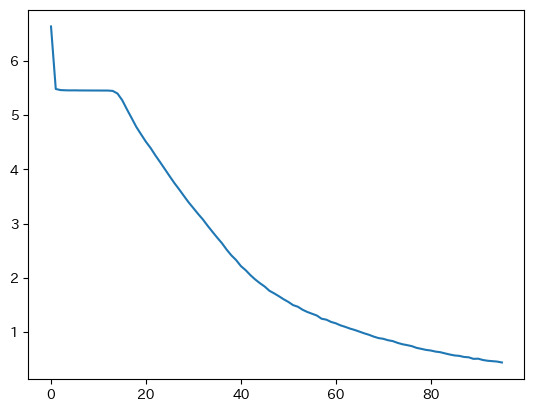

epoch:97  index:148 loss:0.424011
source 鳴く の で は なかろう か と 考え た 。 
target しかし
output しかし

epoch:98  index:148 loss:0.416870
source た 。 「 家人 が 餌 を やら ない もの 
target だ
output だ

epoch:99  index:148 loss:0.406786
source ぬ もの を 籠 へ 入れ て 、 しかも 餌 
target を
output を

epoch:100  index:148 loss:0.405685
source 釣鐘 の よう に 静か で ある 。 さすが に 
target 文鳥
output し

epoch:101  index:148 loss:0.384013
source は 可 愛想 な 事 を 致し まし た と 
target ある
output 、



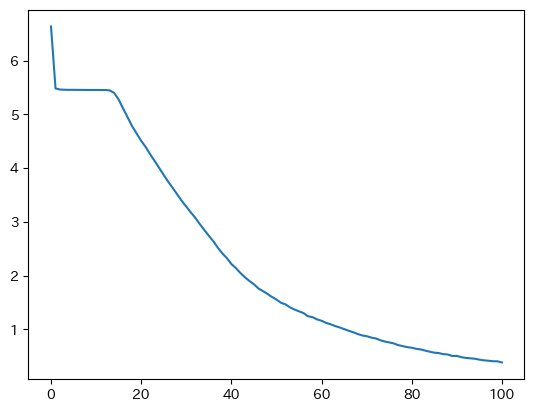

epoch:102  index:148 loss:0.370756
source 粟 と 水 を 眺め た 。 自分 は 食事 
target を
output を

epoch:103  index:148 loss:0.366771
source 女 の 眉 は 心持 八 の 字 に 寄っ 
target て
output て

epoch:104  index:148 loss:0.355806
source て 、 いっしょ に 午飯 を 食う 。 いっしょ に 
target 晩飯
output 晩飯

epoch:105  index:148 loss:0.359308
source 、 ちょっと 首 を 曲げ て 人 を 見る 癖 
target が
output で

epoch:106  index:148 loss:0.349059
source 、 自分 が 餌 を やる 水 を やる 。 
target 籠
output 籠



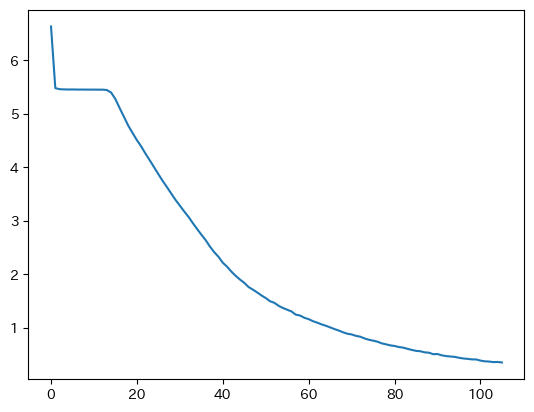

epoch:107  index:148 loss:0.331329
source 程 、 こちら は 愈 〻 幼稚 な もの で 
target あっ
output あっ

epoch:108  index:148 loss:0.322433
source 這入っ て 来 ない 習慣 で あっ た 。 筆 
target の
output の

epoch:109  index:148 loss:0.316322
source 水 も まだ ある 。 文鳥 は 満足 し て 
target いる
output いる

epoch:110  index:148 loss:0.302180
source へ 帰っ て 淋しく ペン を 紙 の 上 に 
target 走らし
output 走らし

epoch:111  index:148 loss:0.304079
source 筆 を 挟ん だ まま 手の平 へ 顎 を 載せ 
target て
output て



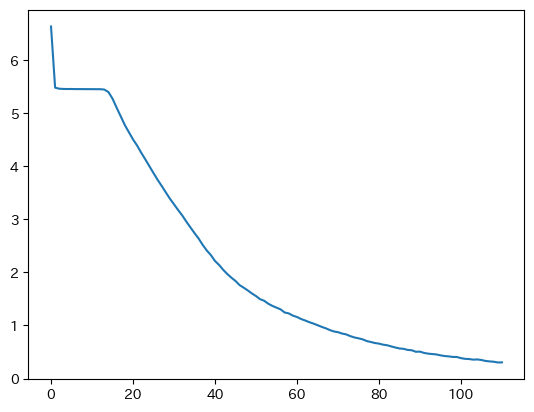

epoch:112  index:148 loss:0.299328
source に 書斎 へ 這入る つもり で 例 の 縁側 へ 
target 出
output 出

epoch:113  index:148 loss:0.288602
source が する 。 家 の もの が 忘れる 時 は 
target 、
output 、

epoch:114  index:148 loss:0.277493
source 当人 が 承知 だ って 、 そんな 所 へ 嫁 
target に
output に

epoch:115  index:148 loss:0.282842
source から 見 たら まずい 詩 で は あろう が 、 
target 先ず
output 先ず

epoch:116  index:148 loss:0.274125
source いる 。 自分 は 粟 も 水 も 易え ず 
target に
output 、



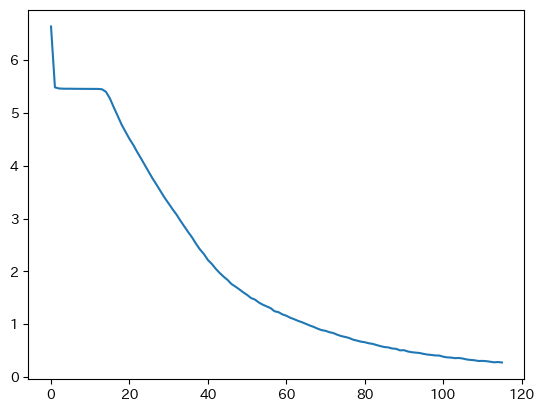

epoch:117  index:148 loss:0.261681
source 木 の 上 に 戻っ た 。 白い 首 を 
target 半ば
output 半ば

epoch:118  index:148 loss:0.259590
source 知っ て い た の で 、 話す に 足る 
target と
output と

epoch:119  index:148 loss:0.247169
source 気 に なら ない 。 枕元 に ある 新聞 を 
target 手
output 手

epoch:120  index:148 loss:0.245101
source て お やり なさい と つけ加え た 。 三重吉 は 
target 文鳥
output 文鳥

epoch:121  index:148 loss:0.244752
source 。 夢 に 文鳥 を 背負い込ん だ 心持 は 、 
target 少し
output 少し



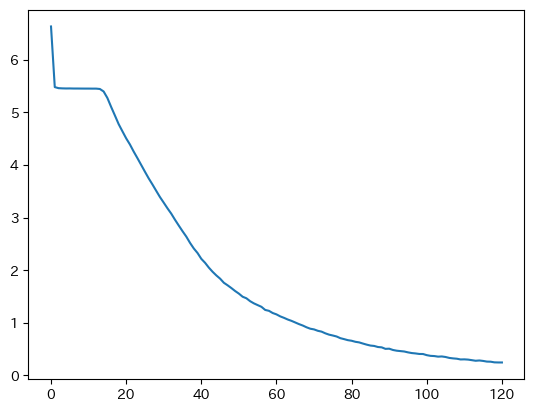

epoch:122  index:148 loss:0.234801
source 頬杖 を 突い たり やめ たり し て 暮し て 
target い
output い

epoch:123  index:148 loss:0.231484
source 。 時 は 宵の口 で あっ た 。 寒い から 
target 火鉢
output 火鉢

epoch:124  index:148 loss:0.234745
source 恰好 の 好い 頸 を 肩 まで すくめ て い 
target た
output た

epoch:125  index:148 loss:0.218066
source が 出 て 、 霜 が 降っ て い た 
target 。
output 。

epoch:126  index:148 loss:0.217254
source から たまら ない 。 それ から 其 『 月 の 
target 都
output 都



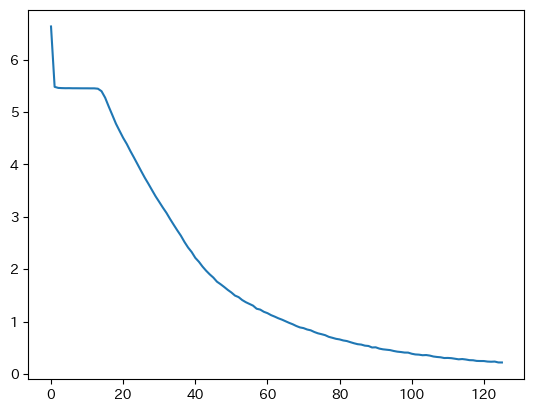

epoch:127  index:148 loss:0.211405
source 易え て やっ た 。 水道 の 水 だ から 
target 大変
output 大変

epoch:128  index:148 loss:0.203566
source た 顎 を 一応 撮ん で 見る 。 それ で 
target も
output も

epoch:129  index:148 loss:0.209717
source 遣っ て しまっ た もの で あろう 。 併し 其 
target 前
output 前

epoch:130  index:148 loss:0.202477
source 。 其 頃 僕 も 詩 や 漢文 を 遣っ 
target て
output て

epoch:131  index:148 loss:0.201241
source つ 二 つ 話そう か 。 正岡 と いう 男 
target は
output は



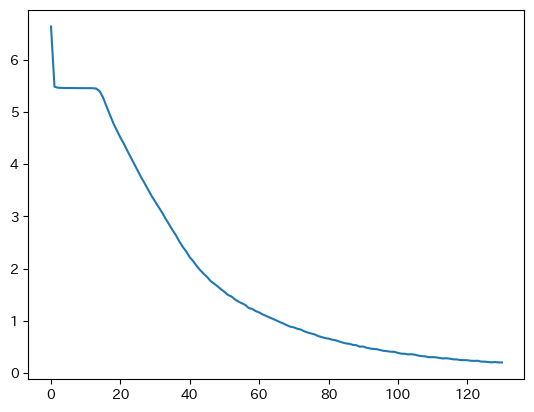

epoch:132  index:148 loss:0.194602
source つけ た 。 下女 は それ で も 黙っ て 
target いる
output 、

epoch:133  index:148 loss:0.182377
source 、 僕 は 蒲焼 の 事 を 一番 よく 覚え 
target て
output て

epoch:134  index:148 loss:0.181877
source 。 或 時 又 来 て 呉れ と いう 。 
target 僕
output 僕

epoch:135  index:148 loss:0.179675
source 書こう と 思っ て 、 二三 行 書き出す と 、 
target 文鳥
output 文鳥

epoch:136  index:148 loss:0.172027
source 。 昔 の 女 の 顔 も つい 思い出さ なかっ 
target た
output た



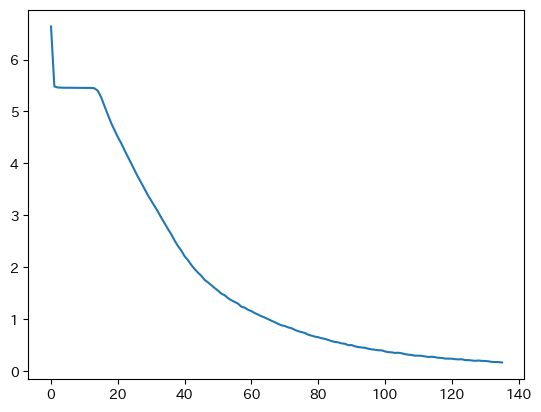

epoch:137  index:148 loss:0.169960
source 易え ず に 書斎 へ 引込ん だ 。 昼過ぎ また 
target 縁側
output 縁側

epoch:138  index:148 loss:0.178692
source よう な 寛大 な 事 を 云う 。 で も 
target 君
output 君

epoch:139  index:148 loss:0.169954
source 。 何 で も 大将 に なら なけりゃ 承知 し 
target ない
output ない

epoch:140  index:148 loss:0.165798
source も これ に は 驚い た 。 其 上 まだ 
target 金
output 金

epoch:141  index:148 loss:0.169666
source だけ は 抜い た と 見える 。 自分 が 炭取 
target に
output の



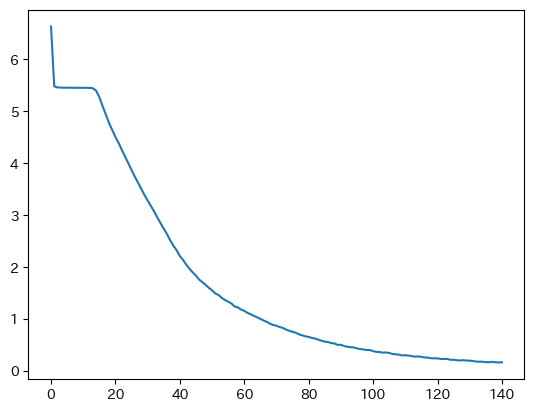

epoch:142  index:148 loss:0.161432
source て 戸 を 明ける と 、 文鳥 は 例 に 
target 似
output 似

epoch:143  index:148 loss:0.165064
source 驚い て 台所 の 方 へ 持っ て 行っ た 
target 。
output 。

epoch:144  index:148 loss:0.160330
source て 黙然 と し て 、 籠 の 中 に 
target 片づい
output 片づい

epoch:145  index:148 loss:0.146935
source 直線 に 伸ばし て い た 。 自分 は 籠 
target の
output の

epoch:146  index:148 loss:0.146525
source 発達 せ ず 、 まるで わから ん 処 へ 持っ 
target て
output て



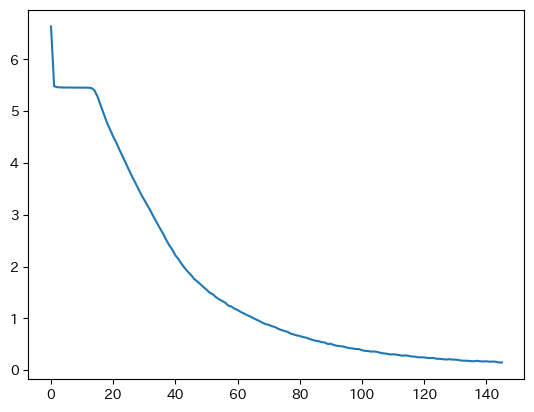

epoch:147  index:148 loss:0.151572
source 前 へ かしこまっ て 、 籠 の 戸 を 開い 
target て
output て

epoch:148  index:148 loss:0.148114
source を 箱 から 出す や 否 や 、 文鳥 は 
target 白い
output 白い

epoch:149  index:148 loss:0.147773
source ませ ん から 。 水 も 毎朝 かえ て お 
target やん
output やん

epoch:150  index:148 loss:0.134052
source 。 三重吉 は 大 得意 で ある 。 まあ 御覧 
target なさい
output なさい



In [ ]:
#@title Train

# Epoch数まで繰り返し
for epoch in range(start_epoch, epoch_num):

    # 損失の累計をリセット
    running_loss = 0.0

    # 学習モードに変更
    model.train()

    # 学習データセット全体をバッチ単位で処理
    for i, batch in enumerate(train_dataloader):

        # 入力元データと教師データ
        source = batch['source'].to(device)
        target = batch['target'].to(device).view(-1)

        # 勾配のリセット
        optimizer.zero_grad()

        # 推論
        outputs, w = model(source, mask)

        # 損失計算
        loss = criterion(outputs, target)

        # 誤差逆伝播
        loss.backward()

        # 学習パラメータの更新
        optimizer.step()

        # 損失の累積
        running_loss += loss.item()

        # print( i , len(train_dataloader))

    # 損失の履歴を作成
    train_loss = running_loss / len(train_dataloader)
    history["train_loss"].append(train_loss)

    # 開始epochの更新
    start_epoch = epoch

    # 損失の確認
    if epoch % 1 == 0:
        print(f"epoch:{epoch+1}  index:{i+1} loss:{train_loss:.6f}")
        evaluate.predict(source, target, outputs)

    # グラフの描画
    if epoch % 5 == 0 and epoch != 0:
        plt.plot(history['train_loss'])
        plt.show()

    # モデルの保存
    if epoch % 10 == 0 and epoch != 0:
        torch.save(model.state_dict(), pre_trained_model_path )


    ## 可視化の処理（Epochごとに重みを格納します）
    # 評価モードに変更
    model.eval()
    # 推論
    _, w = model(source)
    # Attentionの潜在空間の履歴を作成
    attn_list.append(w[0].detach())

In [ ]:
torch.save(model.state_dict(), pre_trained_model_path )

# Test

In [ ]:
# モデルの読み込み
model.load_state_dict(torch.load(pre_trained_model_path))
# 評価モードに設定
_ = model.eval()

<ipython-input-56-75db2e08215f>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pre_trained_model_path))


https://www.aozora.gr.jp/cards/000148/files/753_42587.html

In [ ]:
sample_corpus = "何しろ言いだしたものに責任を負わせるのは" #@param{type:"string"}
parsed_corpus = tagger.parse(sample_corpus)
print(sample_corpus)
evaluate.generate(parsed_corpus, model, mask)

何しろ言いだしたものに責任を負わせるのは
のは当然の事だから、さっそく万事を三重吉に依頼する事にした。すると、すぐ金を出せと云う。金はたしかに出した。三重吉はどこで買ったか、七子の三つ折の紙入を懐中していて、人の金でも自分も金でも悉皆この紙入の中に入れる癖がある。自分は三重吉が五円札をたしかにこの紙入の底へ押し込んだのを目撃した。かようにして金はたしかに三重吉の手に落ちた。しかし鳥と籠とは容易にやって来ない。そのうち秋が小春になった。三重吉はたびたび来る。よく女の話などをして帰って行く。文鳥と籠の講釈は全く出ない。硝子戸を透して五尺の縁側には日が好く当る。どうせ文鳥を飼うなら、こんな暖かい季節に、この縁側へ鳥籠を据えてやったら、文鳥の定めし鳴き善かろうと思うくらいであった。三重吉の小説によると、文鳥は千代千代と鳴くそうである。その鳴き声がだいぶん気に入ったと見えて、三重吉は千代千代を何度となく使っている。あるいは千代と云う女に惚れていた事があるのかも知れない。しかし当人はいっこうそんな事を云わない。自分も聞いてみない。ただ縁側に日が善く当る。そうして文鳥が鳴かない。そのうち霜が降り出した。自分は毎日伽藍のような書斎に、寒い顔を片づけてみたり、取乱してみたり、頬杖を突いたりやめたりして暮していた。戸は二重に締め切った。火鉢に炭ばかり継いでいる。文鳥はついに忘れた。ところへ三重吉が門口から威勢よく這入って来た。時は宵の口であった。寒いから火鉢の上へ胸から上を翳して、浮かぬ顔をわざとほてらしていたのが、急に陽気になった。三重吉は豊隆を従えている。豊隆はいい迷惑である。二人が籠を一つずつ持っている。その上に三重吉が大きな箱を兄き分に抱えている。五円札が文鳥と籠と箱になったのはこの初冬の晩であった。三重吉は大得意である。まあ

# 重みの可視化

In [ ]:
#@title グラフ描画モジュールのインストール
!apt-get -y install fonts-ipafont-gothic
!pip install japanize-matplotlib

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-ipafont-gothic is already the newest version (00303-21ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
# 可視化モジュールの読み込み
from whiteGPT.utils.functions.visualize_attention_weights import visualize_attention_weights

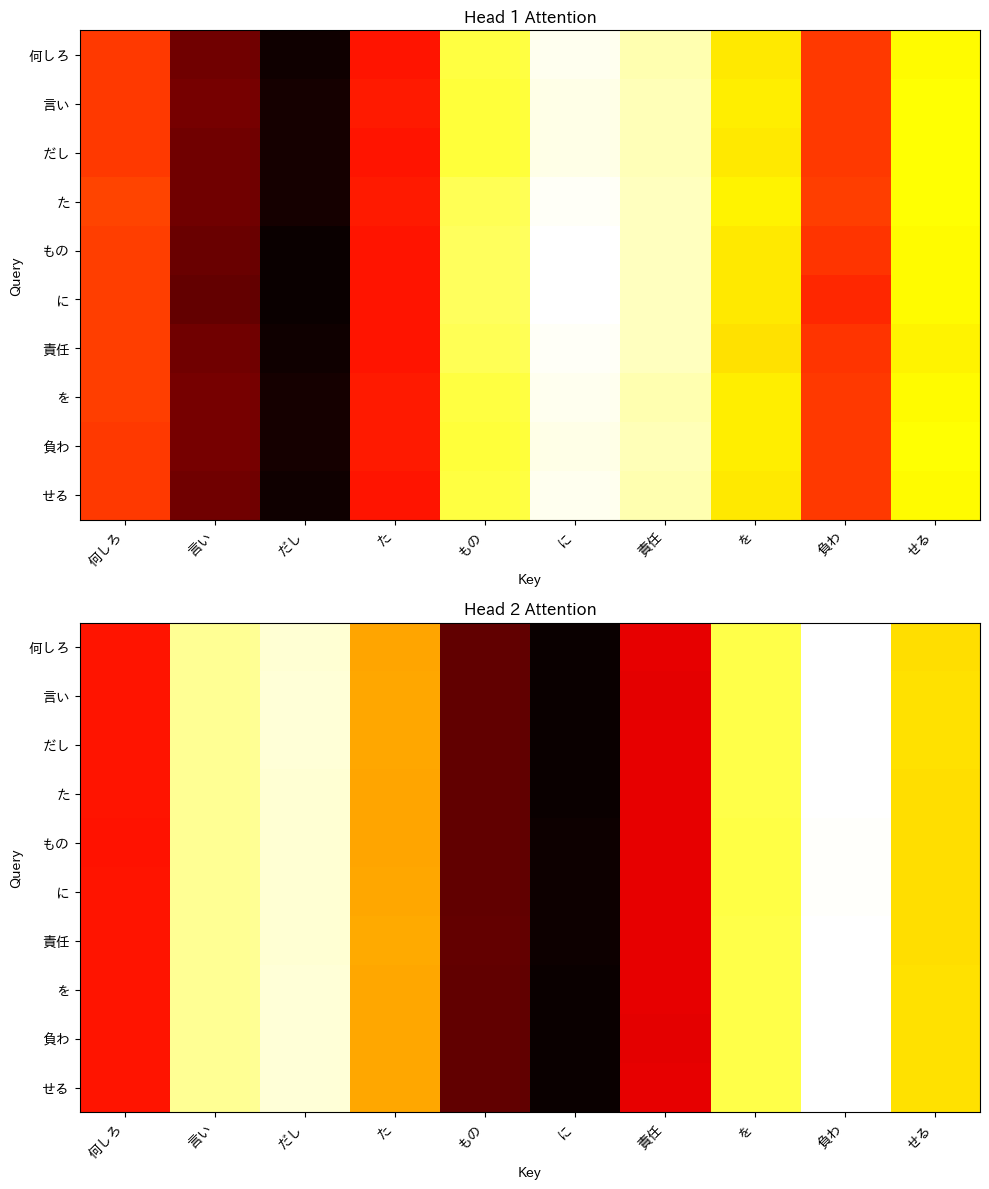

In [ ]:
# @title 未学習のモデルで視覚化
baby_model = GPT(vocab_size, context_size, d_model, n_head, n_block)
baby_model.to(device)
baby_model.eval()
inputs = evaluate.input_tokens(parsed_corpus)
_, w = baby_model(inputs)
visualize_attention_weights(w[0].cpu(), parsed_corpus) # バッチの次元は除外

In [ ]:
w.shape

torch.Size([1, 2, 10, 10])

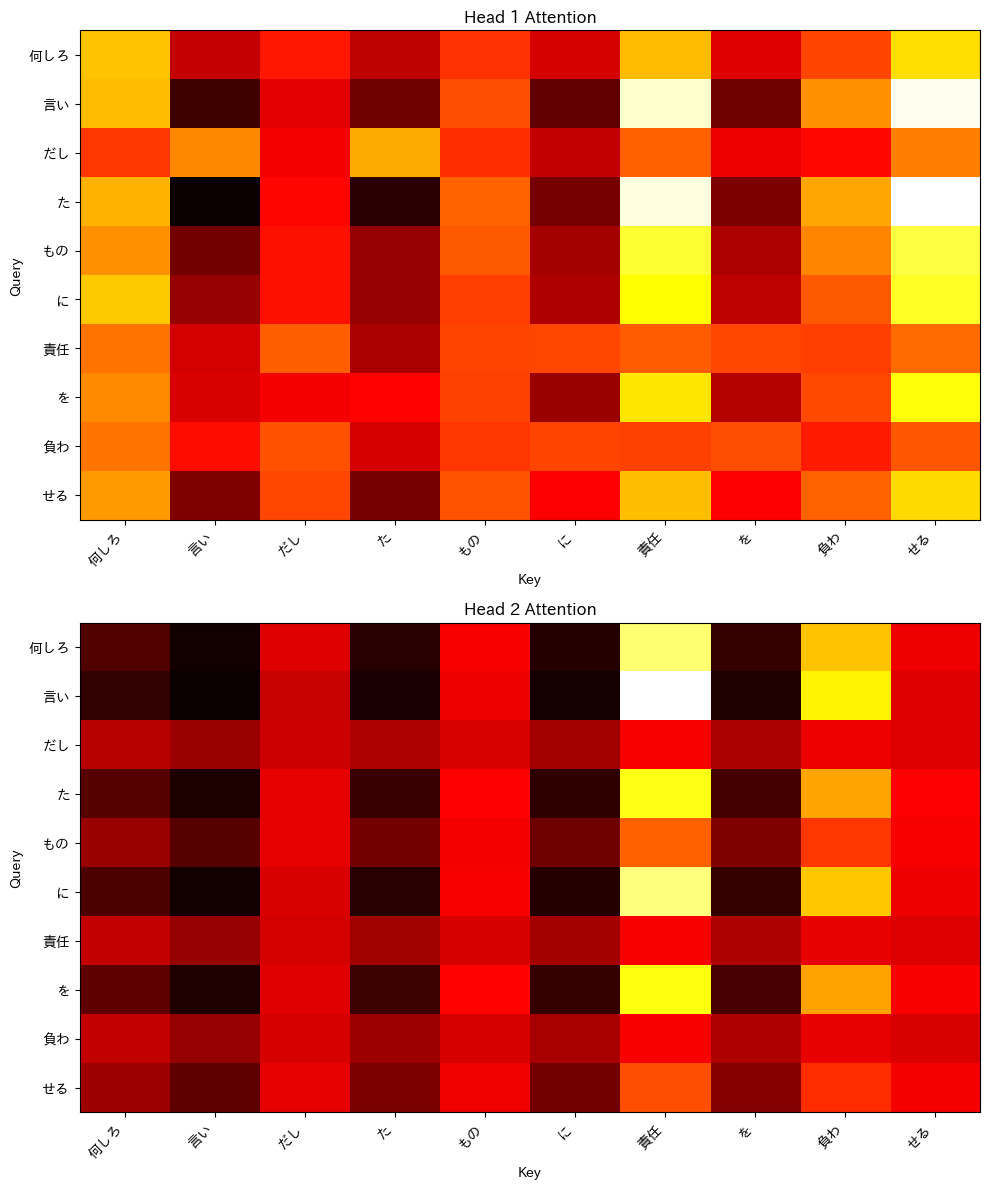

In [71]:
# @title 学習中のモデルで視覚化
inputs = evaluate.input_tokens(parsed_corpus)
model.eval()
inputs = inputs.to(device)
model.to(device)
_, w = model(inputs)
# outputs, w = model(inputs, mask)
visualize_attention_weights(w[0].cpu(), parsed_corpus) # バッチの次元は除外